# Building your own Dystopic Surveillance State with Python

## Adam Kariv

![](cover.png)

(Credit: Getty images, from https://www.bbc.com/future/article/20220616-the-nation-where-your-faceprint-is-already-being-tracked)

![Chinese government](example7.png)

(https://www.technologyreview.com/2022/06/22/1054586/hikvision-worlds-biggest-surveillance-company/)

![face projector](example6.png)

![HongKong protesters](example5.png)

(https://news.sbs.co.kr/news/endPage.do?news_id=N1005493271&plink=INTEREST&cooper=SBSNEWSMAIN)

![Europe Facial Recognition DB](example3.png)

(https://www.wired.com/story/europe-police-facial-recognition-prum/)

![MasterCard](example4.png)

(https://theconversation.com/pay-with-a-smile-or-a-wave-why-mastercards-new-face-recognition-payment-system-raises-concerns-183447)

![FR in stores](example2.png)

(https://theconversation.com/bunnings-kmart-and-the-good-guys-say-they-use-facial-recognition-for-loss-prevention-an-expert-explains-what-it-might-mean-for-you-185126)

![Pride parade](example1.png)

(https://www.haaretz.com/israel-news/2022-06-02/ty-article/.premium/israel-arrests-21-year-old-over-pride-march-death-threats/00000181-2328-d7db-a98f-a7fb34980000)

## `import face_recognition`

In [1]:
import face_recognition

from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.autolayout'] = True

%reload_ext autoreload
%autoreload 2

In [2]:
PHOTOS_DIR = Path('2019-photos')
PHOTOS_SUBSET_DIR = Path('2019-photos-subset')
MY_FACE_FILE = 'IMG_6689_6II.jpg'
GROUP_PHOTO_FILE = 'IMG_6317_6II.jpg'

![Chart](js-py-chart.png)

## Simple find face in image

[(139, 1026, 325, 840), (184, 838, 339, 683)]

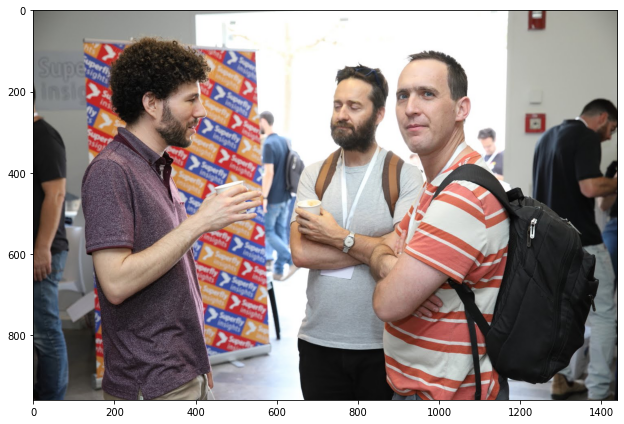

In [3]:
image = face_recognition.load_image_file(PHOTOS_DIR / MY_FACE_FILE)
face_locations = face_recognition.face_locations(image)
plt.imshow(image)
face_locations


## Each face location is `(top, right, bottom, left)`

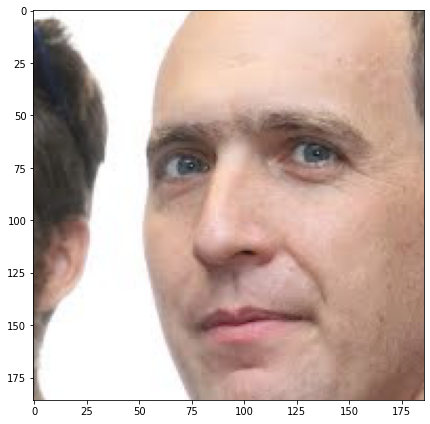

In [4]:
top, right, bottom, left = face_locations[0]
plt.imshow(image[top:bottom, left:right])

## Face landmarks

![](68-landmarks.png)

In [5]:
face_landmarks = face_recognition.face_landmarks(image)[0]
print(face_landmarks.keys())
print(face_landmarks['nose_tip'])

dict_keys(['chin', 'left_eyebrow', 'right_eyebrow', 'nose_bridge', 'nose_tip', 'left_eye', 'right_eye', 'top_lip', 'bottom_lip'])
[(919, 261), (924, 264), (931, 265), (940, 261), (948, 259)]


In [6]:
from face_recognition.api import _raw_face_landmarks

def landmarks(image):
    locations = face_recognition.face_locations(image, 2, 'hog')
    return [i.parts() for i in _raw_face_landmarks(image, locations)]

raw_face_landmarks = landmarks(image)[0]
print(raw_face_landmarks)
print(len(raw_face_landmarks))

points[(895, 228), (894, 244), (894, 262), (899, 280), (904, 297), (910, 311), (918, 328), (927, 342), (943, 346), (963, 344), (986, 336), (1006, 324), (1024, 309), (1034, 290), (1039, 268), (1041, 245), (1041, 223), (895, 208), (897, 198), (905, 194), (915, 193), (925, 196), (939, 194), (954, 188), (972, 187), (989, 192), (1000, 204), (931, 208), (928, 221), (925, 234), (923, 248), (918, 261), (924, 264), (931, 265), (940, 262), (948, 259), (902, 217), (908, 209), (916, 209), (924, 215), (917, 217), (908, 218), (959, 212), (967, 204), (976, 204), (985, 210), (977, 212), (968, 212), (918, 293), (922, 286), (929, 282), (935, 283), (942, 280), (955, 282), (971, 286), (956, 292), (944, 296), (937, 297), (930, 298), (924, 298), (921, 292), (929, 289), (936, 289), (943, 287), (966, 286), (943, 288), (936, 290), (929, 290)]
68


## Affine Transformations

![](affine-transformations.png)

## Straighten face and resize it to a fixed size

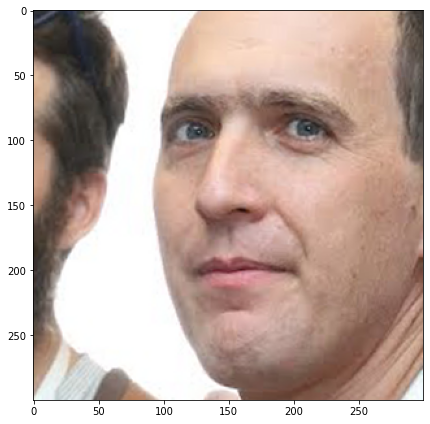

In [7]:
def thumbnail(image, landmarks):
    top_point = landmarks[27]     # 51
    bottom_point = landmarks[57]
    middle_point = (top_point + bottom_point) / 2

    rotation = -np.arctan((top_point.x - bottom_point.x) / (top_point.y - bottom_point.y))
    scale = 125.0/np.sqrt((top_point.x - bottom_point.x)**2 + (top_point.y - bottom_point.y)**2)
    size = 300

    # recenter resultant image
    T_pos = np.array([
        [1, 0, size/2],
        [0, 1, size/2],
        [0, 0, 1]])
    # rotate - opposite angle
    T_rotate = np.array([
        [np.cos(rotation), np.sin(rotation), 0],
        [-np.sin(rotation), np.cos(rotation), 0],
        [0, 0, 1]])
    # scale
    T_scale = np.array([
        [scale, 0, 0],
        [0, scale, 0],
        [0, 0, 1]])
    # center original to 0,0 around middle point
    T_center = np.array([
        [1, 0, -middle_point.x],
        [0, 1, -middle_point.y],
        [0, 0, 1]])
    T = T_pos @ T_rotate @ T_scale @ T_center
    T_inv = np.linalg.inv(T)

    im = Image.fromarray(image.astype('uint8'), 'RGB')

    img_transformed = im.transform((size, size), Image.AFFINE, data=T_inv.flatten()[:6], resample=Image.BICUBIC)
    return np.asarray(img_transformed)

plt.imshow(thumbnail(image, landmarks(image)[0]))


![](stalin.jpg)

## Group Photo - Detect multiple faces

Got 19 faces


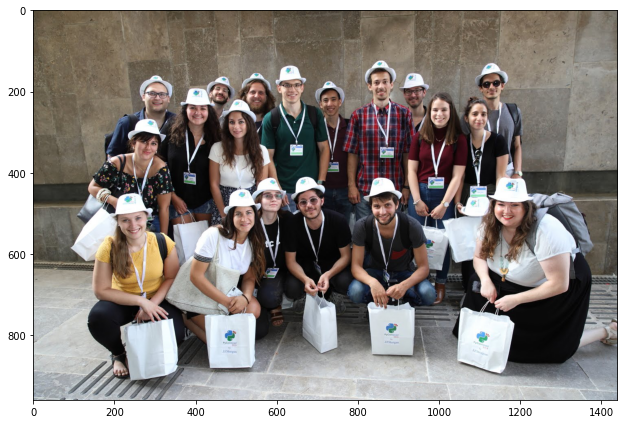

In [8]:
group_image = face_recognition.load_image_file(PHOTOS_DIR / GROUP_PHOTO_FILE)
faces = landmarks(group_image)
print(f'Got {len(faces)} faces')
plt.imshow(group_image)

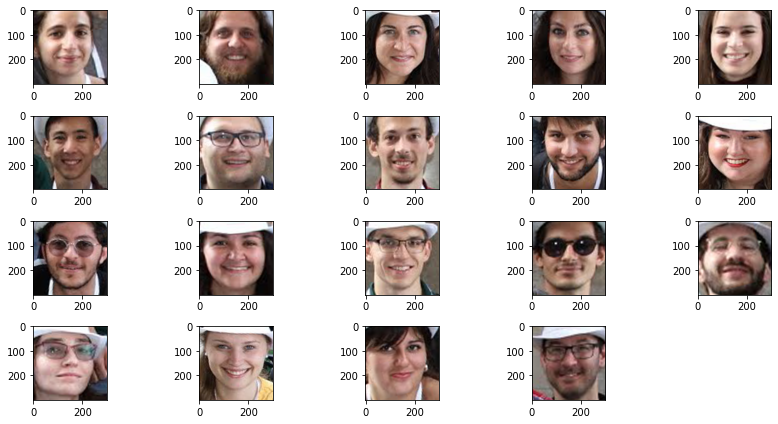

In [9]:
for i in range(len(faces)):
    plt.subplot(4,5,i+1)
    plt.imshow(thumbnail(group_image, faces[i]))

## Is it the same person?

## Let's use the 'encoding' to compare faces

In [10]:
from utils import scan_all_faces
encodings, faces = scan_all_faces(PHOTOS_SUBSET_DIR)
print(faces[0].keys())
print(encodings.shape)

Loaded 28 faces from file
dict_keys(['photo', 'location', 'landmarks', 'encoding', 'index'])
(28, 128)


## What's a good threshold?

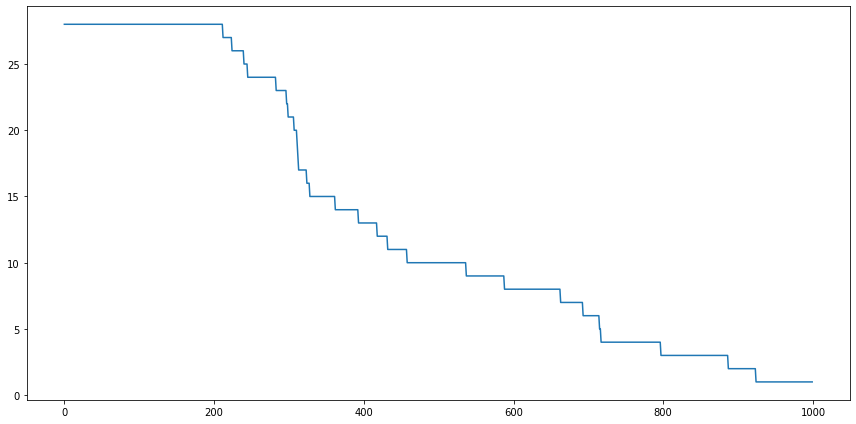

In [11]:
from sklearn.cluster import AgglomerativeClustering

results = []
for dt in range(1000):
    clustering = AgglomerativeClustering(n_clusters=None, linkage='complete', memory='.cache', distance_threshold=dt/1000)
    result = clustering.fit(encodings)
    results.append(len(set(result.labels_)))

plt.plot(results)

## Let's see it in action

[4 2 8 6 1 4 4 6 2 1 2 8 6 1 4 0 3 4 5 7 0 3 4 4 3 0 5 7]


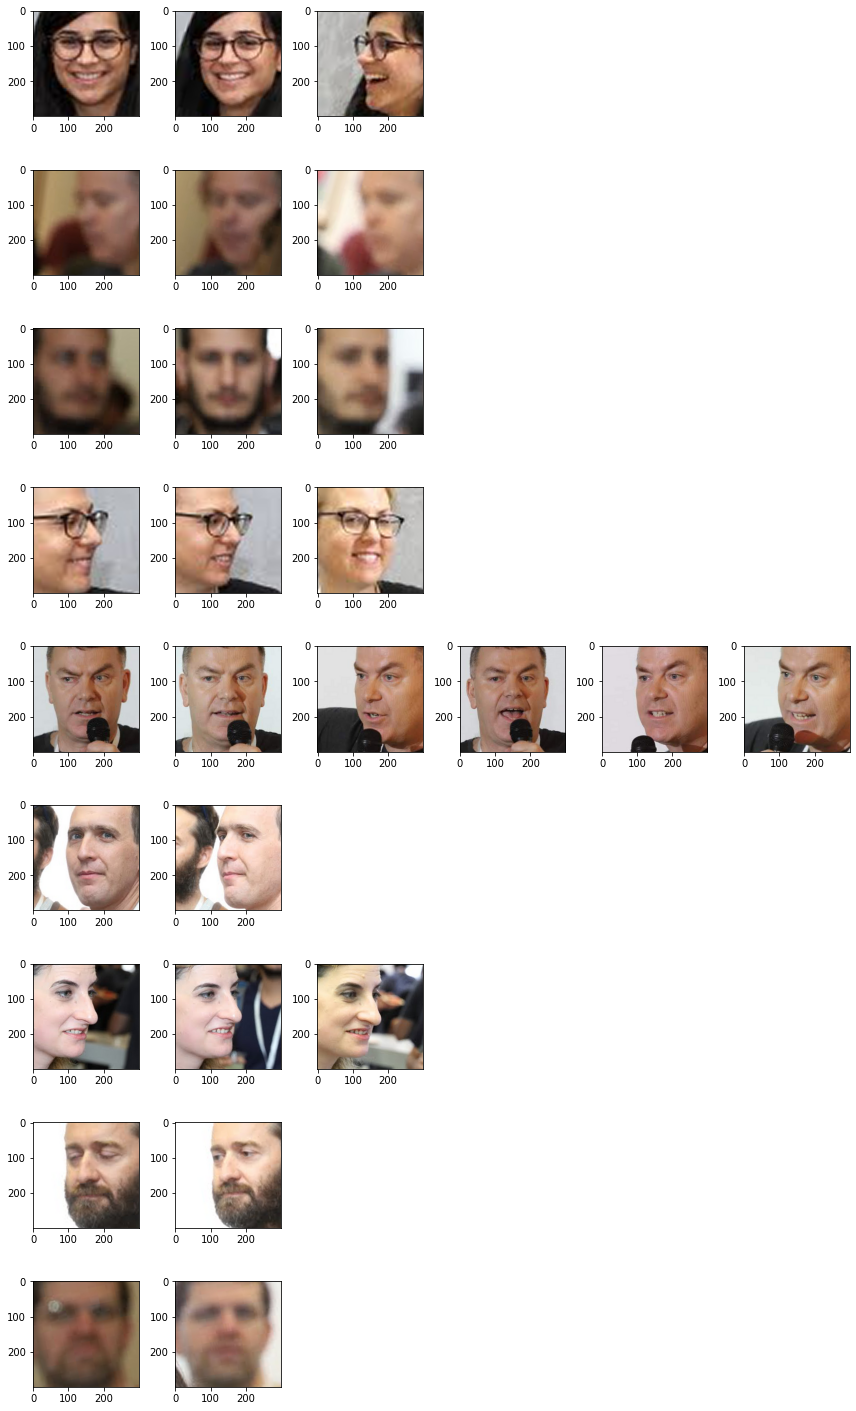

In [12]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(n_clusters=None, linkage='complete', memory='.cache', distance_threshold=0.55)
result = clustering.fit(encodings)
print(result.labels_)
max_label = max(result.labels_)+1
with plt.rc_context({'figure.figsize': [12, 20]}):
    for lbl in range(max_label):
        for i, idx in enumerate(np.where(result.labels_ == lbl)[0]):
            plt.subplot(max_label,6,lbl*6 + i+1)
            plt.imshow(thumbnail(
                face_recognition.load_image_file(faces[idx]['photo']),
                faces[idx]['landmarks']
            ))


## Who's the most photographed person?

Loaded 3489 faces from file
[(49, 42), (69, 37), (79, 36), (20, 31), (6, 28), (305, 27), (142, 27), (369, 27), (194, 27), (61, 27), (5, 27), (360, 25), (28, 24), (127, 24), (154, 24), (267, 23), (140, 23), (506, 22), (283, 22), (77, 22)]


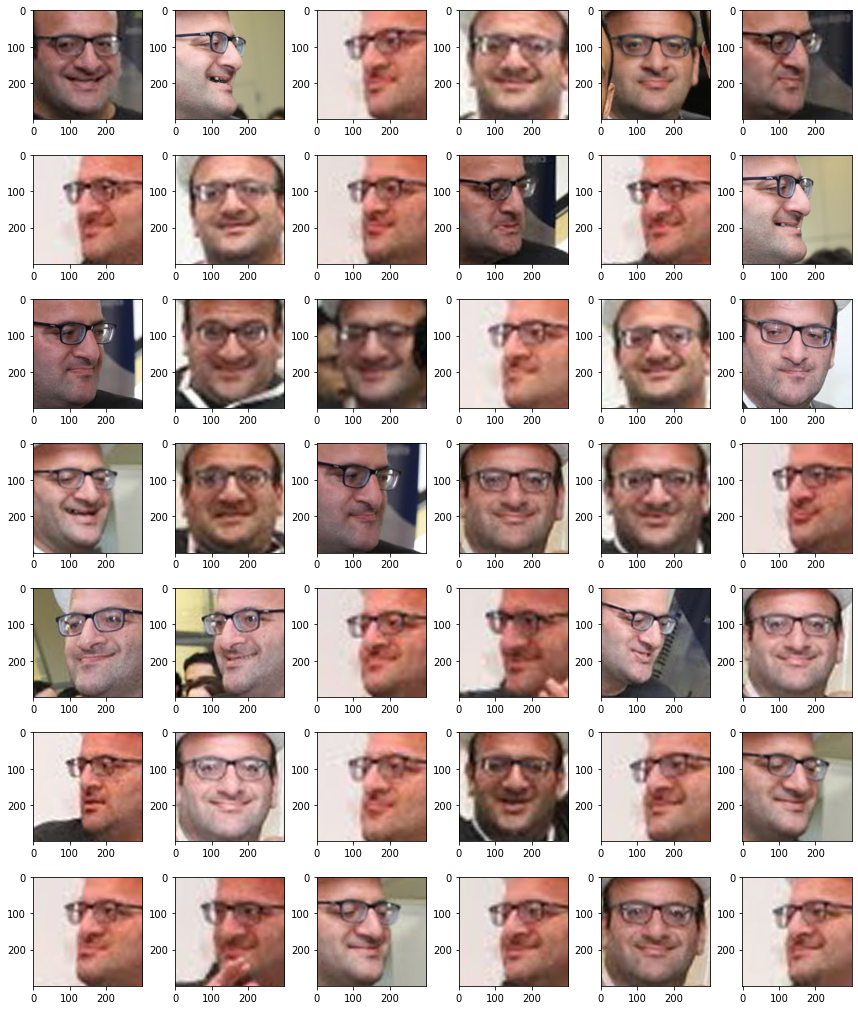

In [13]:
from collections import Counter

all_encodings, all_faces = scan_all_faces(PHOTOS_DIR)
clustering = AgglomerativeClustering(n_clusters=None, linkage='complete', memory='.cache', distance_threshold=0.55)
result = clustering.fit(all_encodings)
clusters = result.labels_
most_common = Counter(clusters).most_common(20)
print(most_common)
most_common_person = most_common[0][0]
with plt.rc_context({'figure.figsize': [12, 30]}):
    for i, idx in enumerate(np.where(clusters == most_common_person)[0]):
        plt.subplot(15,6,i+1)
        plt.imshow(thumbnail(
            face_recognition.load_image_file(all_faces[idx]['photo']),
            all_faces[idx]['landmarks']
        ))



## Men vs Women

processed 0 photos, collected 1 faces
processed 1000 photos, collected 443 faces
processed 2000 photos, collected 547 faces
processed 3000 photos, collected 606 faces


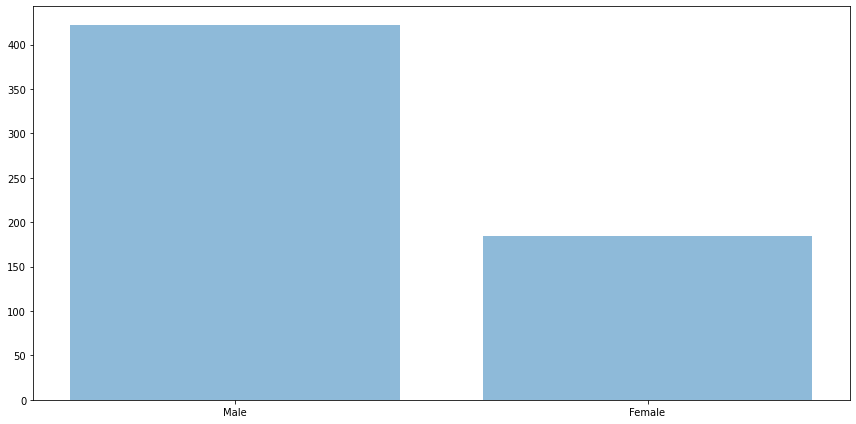

In [14]:
import cv2

# The gender model architecture
GENDER_MODEL = 'weights/deploy_gender.prototxt'
# The gender model pre-trained weights
GENDER_PROTO = 'weights/gender_net.caffemodel'
# Each Caffe Model impose the shape of the input image also image preprocessing is required like mean
# substraction to eliminate the effect of illumination changes
MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)
# Represent the gender classes
GENDER_LIST = ['Male', 'Female']

gender_net = cv2.dnn.readNetFromCaffe(GENDER_MODEL, GENDER_PROTO)
gender_by_cluster = dict()
gender_by_face_idx = dict()

for i, face in enumerate(all_faces):
    thumb = thumbnail(face_recognition.load_image_file(face['photo']), face['landmarks'])
    blob = cv2.dnn.blobFromImage(
        image=thumb, scalefactor=1.0, size=(227, 227),
        mean=MODEL_MEAN_VALUES, swapRB=True, crop=False
    )
    # Predict Gender
    gender_net.setInput(blob)
    gender_preds = gender_net.forward()
    gender_by_face_idx[i] = gender_preds
    gender_by_cluster.setdefault(clusters[i], []).append(gender_preds)
    if i % 1000 == 0:
        print(f'processed {i} photos, collected {len(gender_by_cluster)} faces')

gender_by_cluster = dict((k, np.mean(v, axis=0)) for k, v in gender_by_cluster.items())
gender_counter = Counter(
    GENDER_LIST[v.argmax()] for v in gender_by_cluster.values()
)
counts = gender_counter.most_common()
plt.bar(GENDER_LIST, [gender_counter[g] for g in GENDER_LIST], align='center', alpha=0.5)
plt.show()


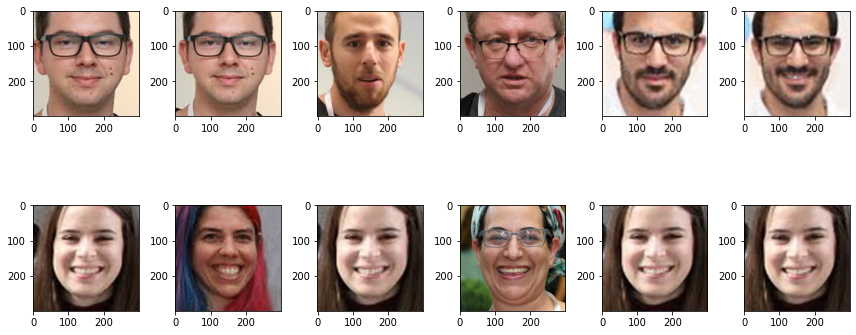

In [15]:
most_feminine = sorted(gender_by_face_idx.keys(), key=lambda k: gender_by_face_idx[k][0][0])
most_masculine = sorted(gender_by_face_idx.keys(), key=lambda k: gender_by_face_idx[k][0][1])

for i, row in enumerate([most_masculine, most_feminine]):
    for j in range(6):
        face = all_faces[row[j]]
        plt.subplot(2,6,i*6 + j + 1)
        plt.imshow(thumbnail(face_recognition.load_image_file(face['photo']), face['landmarks']))

## Live Demo Time

In [18]:
import cv2
from utils import scan_all_faces

print(cv2.ocl.useOpenCL())

all_encodings, all_faces = scan_all_faces(PHOTOS_DIR)

WINDOW = 'Face'
cv2.namedWindow(WINDOW)
cv2.startWindowThread()
cv2.imshow(WINDOW, np.zeros((200, 200, 3)))

cap = cv2.VideoCapture(1200)
# cap = cv2.VideoCapture(0)

while True:
    _, image = cap.read()
    
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    locations = face_recognition.face_locations(rgb_image, 0)[:1]
    if len(locations) > 0:
        landmarks = [i.parts() for i in _raw_face_landmarks(rgb_image, locations)][0]
        encoding = face_recognition.face_encodings(rgb_image, locations, num_jitters=2, model='large')[0]
        thumb = thumbnail(image, landmarks)
        
        max_dist = 0.5
        best_face = None
        for face in all_faces:
            if (dist := np.linalg.norm(face['encoding'] - encoding)) < max_dist:
                max_dist = dist
                best_face = face

        frame = np.zeros((thumb.shape[0], thumb.shape[1]*2, 3), dtype=np.uint8)
        frame[:, :thumb.shape[1]] = thumb
        if best_face is not None:
            best_thumb = thumbnail(
                face_recognition.load_image_file(best_face['photo']),
                best_face['landmarks']
            )
            best_thumb = cv2.cvtColor(best_thumb, cv2.COLOR_BGR2RGB)
            frame[:, thumb.shape[1]:] = best_thumb
            cv2.putText(frame, f'{best_face["index"]}, {max_dist}', 
                        (thumb.shape[1] + 10, 50),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (200, 200, 255), 2)

        cv2.imshow(WINDOW, frame)
    if cv2.waitKey(1) == ord('x'):
        cap.release()
        cv2.waitKey(10)
        cv2.destroyAllWindows()
        cv2.waitKey(10)
        del cap
        break


True
Loaded 3489 faces from file
